In [1]:
import numpy as np
from scipy.stats import rice
from scipy.special import i0
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import matplotlib


def ivim_signal(b, S0, D, f, D_star):
    """
    Calculates the IVIM signal under the bi-exponential model.

    Args:
        b (array-like): b-values
        S0 (float): Initial signal amplitude 
        D (float): True diffusion coefficient
        f (float): Perfusion fraction
        D_star (float): Pseudodiffusion coefficient

    Returns:
        array-like: IVIM signal values
    """
    return S0 * (f * np.exp(-b * D_star) + (1 - f) * np.exp(-b * D)) 

def jacobian(b, S0, D, f, D_star):
    """
    Calculates the Jacobian matrix of the IVIM signal model.

    Args:
        b (array-like): b-values
        S0 (float): Initial signal amplitude 
        D (float): True diffusion coefficient
        f (float): Perfusion fraction
        D_star (float): Pseudodiffusion coefficient

    Returns:
        numpy.ndarray: Jacobian matrix
    """
    dSdS0 = f * np.exp(-b * D_star) + (1 - f) * np.exp(-b * D)
    dSdD = -S0 * (1 - f) * b * np.exp(-b * D)
    dSdF = S0 * (np.exp(-b * D_star) - np.exp(-b * D))
    dSdDstar = -S0 * f * b * np.exp(-b * D_star)
    return np.stack([dSdS0, dSdD, dSdF, dSdDstar], axis=1)


def crlb(b, S0, D, f, D_star, sigma):
    """
    Calculates the Cramer-Rao Lower Bound (CRLB) for IVIM parameters.

    Args:
        b (array-like): b-values
        S0 (float): Initial signal amplitude 
        D (float): True diffusion coefficient
        f (float): Perfusion fraction
        D_star (float): Pseudodiffusion coefficient
        sigma (float): Standard deviation of Rician noise

    Returns:
        numpy.ndarray: Covariance matrix (the diagonal elements are CRLBs)
    """
    J = jacobian(b, S0, D, f, D_star)
    fisher_info = (J.T @ J) / sigma**2 
    return np.linalg.inv(fisher_info)  

# Example usage:
b_values = np.array([0, 10, 100, 200, 500, 800])
true_S0 = 1.0  # mm^2/s
true_D = 0.001  # mm^2/s
true_f = 0.15
true_D_star = 0.02  # mm^2/s
sigma = 0.05  # Standard deviation of noise

crlb_matrix = crlb(b_values, true_S0, true_D, true_f, true_D_star, sigma)

std_D = np.sqrt(crlb_matrix[1,1]);
std_f = np.sqrt(crlb_matrix[2,2]);
std_D_star = np.sqrt(crlb_matrix[3,3]);

#print("Sqrt CRLB for D:", std_D)
#print("Sqrt CRLB for f:", std_f)
#print("Sqrt CRLB for D*:", std_D_star) 


error_metric = std_D/true_D + std_f +  std_D_star/true_D_star # Not normalizing by true_f, which can be zero
print("Error metric", error_metric) 


Error metric 2.514208947502162


In [2]:
def objective_function_range(b, S0s, Ds, fs, D_stars, sigma):       
    b = np.clip(b,0,1500)
    error_metric = 0.0
    error_metrics = []
    for S0 in S0s:
        for D in Ds:
            for f in fs:
                for D_star in D_stars:
                    crlb_matrix = crlb(b, S0, D, f, D_star, sigma)
                    std_D = np.sqrt(crlb_matrix[1,1]);
                    std_f = np.sqrt(crlb_matrix[2,2]);
                    std_D_star = np.sqrt(crlb_matrix[3,3]);
                    cur_error =  std_D/D + std_f/f +  std_D_star/D_star # Normalizing by true_f, which can be zero
#                    cur_error =  std_D/np.mean(Ds) + std_f/np.mean(fs) +  std_D_star/np.mean(D_stars) # Normalizing by true_f, which can be zero
                    error_metrics = np.append(error_metrics,(cur_error))
    error_metric = np.max(error_metrics)
#    error_metric = np.median(error_metrics)
    return error_metric

# True parameters
true_S0s = np.linspace(1,2,1)  # mm^2/s
true_Ds = np.linspace(0.001,0.002,1)  # mm^2/s
true_fs = np.linspace(0.2,0.4,1)
true_D_stars = np.linspace(0.03,0.1,1)  # mm^2/s
#true_Ds = np.linspace(0.0005,0.0015,3)  # mm^2/s
#true_fs = np.linspace(0.2,0.4,3)
true_D_stars = np.linspace(0.02,0.15,21)  # mm^2/s
sigma = 0.1  # Standard deviation of noise

# Define fixed parameters
fixed_params = {'S0s': true_S0s, 'Ds': true_Ds, 'fs': true_fs, 'D_stars':true_D_stars, 'sigma':sigma}

# Choose an optimization method and provide an initial guess for x
method = 'Nelder-Mead'  # Other options: 'differential_evolution', etc.
b0 = np.logspace(0, 2.5, 50, base=10.0)
#b0 = np.linspace(0, 500, 20)

print(b0)

# Minimize the objective function (using args to pass fixed parameters)
result = minimize(objective_function_range, b0, method=method, args=(fixed_params['S0s'], fixed_params['Ds'], fixed_params['fs'], fixed_params['D_stars'], fixed_params['sigma']),options={'maxiter': 50000, 'maxfev': 200000})
b_opt = np.clip(result.x,0,1500)
b0 = b_opt
result = minimize(objective_function_range, b0, method=method, args=(fixed_params['S0s'], fixed_params['Ds'], fixed_params['fs'], fixed_params['D_stars'], fixed_params['sigma']),options={'maxiter': 50000, 'maxfev': 200000})
b_opt = np.clip(result.x,0,1500)
b_opt = np.sort(b_opt)

#result = differential_evolution(objective_function, bounds,args=(fixed_params['S0'], fixed_params['D'], fixed_params['f'], fixed_params['D_star'], fixed_params['sigma']))
# Check if the optimization was successful
if not result.success:
    print("Optimization failed!")

print("Optimized parameters:", np.round(b_opt))
print("Minimum value: {:.3g}".format(result.fun)) 


[  1.           1.12465782   1.26485522   1.42252931   1.59985872
   1.79929362   2.02358965   2.27584593   2.55954792   2.87861559
   3.23745754   3.64103195   4.09491506   4.60537826   5.17947468
   5.82513671   6.55128557   7.36795456   8.28642773   9.31939576
  10.48113134  11.78768635  13.25711366  14.90971657  16.76832937
  18.85863279  21.20950888  23.85344006  26.82695795  30.17114811
  33.93221772  38.16213408  42.9193426   48.26957438  54.28675439
  61.05402297  68.6648845   77.22449946  86.85113738  97.67781101
 109.8541142  123.54828883 138.94954944 156.27069765 175.75106249
 197.65980717 222.29964825 250.01103826 281.1768698  316.22776602]
Optimization failed!
Optimized parameters: [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 1.000e+00 8.000e+00 1.000e+01 1.400e+01 1.700e+01 2.300e+01 2.700e+01
 2.800e+01 3.100e+01 3.100e+01 3.200e+01 3.300e+01 3.400e+01 3.500e+01
 3.600e+01 3

In [3]:
b0 = b_opt
result = minimize(objective_function_range, b0, method=method, args=(fixed_params['S0s'], fixed_params['Ds'], fixed_params['fs'], fixed_params['D_stars'], fixed_params['sigma']),options={'maxiter': 50000, 'maxfev': 200000})
b_opt = np.clip(result.x,0,1500)
b_opt = np.sort(b_opt)

#result = differential_evolution(objective_function, bounds,args=(fixed_params['S0'], fixed_params['D'], fixed_params['f'], fixed_params['D_star'], fixed_params['sigma']))
# Check if the optimization was successful
if not result.success:
    print("Optimization failed!")

print("Optimized parameters:", np.round(b_opt))
print("Minimum value: {:.3g}".format(result.fun)) 


Optimization failed!
Optimized parameters: [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    2.    9.   10.   14.   17.   24.   27.   28.   32.   32.
   32.   32.   34.   36.   36.   37.   37.   37.   37.   37.   38.   38.
   39.   41.   46.  185.  186.  186.  186.  187.  187.  187.  188.  192.
 1330. 1334.]
Minimum value: 1.32


In [4]:
b0 = b_opt
result = minimize(objective_function_range, b0, method=method, args=(fixed_params['S0s'], fixed_params['Ds'], fixed_params['fs'], fixed_params['D_stars'], fixed_params['sigma']),options={'maxiter': 50000, 'maxfev': 200000})
b_opt = np.clip(result.x,0,1500)
b_opt = np.sort(b_opt)

#result = differential_evolution(objective_function, bounds,args=(fixed_params['S0'], fixed_params['D'], fixed_params['f'], fixed_params['D_star'], fixed_params['sigma']))
# Check if the optimization was successful
if not result.success:
    print("Optimization failed!")

print("Optimized parameters:", np.round(b_opt))
print("Minimum value: {:.3g}".format(result.fun)) 


Optimization failed!
Optimized parameters: [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    2.    9.   10.   15.   19.   23.   26.   28.   31.   31.
   31.   32.   36.   37.   37.   37.   38.   38.   38.   38.   38.   38.
   39.   41.   46.  184.  185.  185.  186.  186.  186.  186.  187.  189.
 1340. 1341.]
Minimum value: 1.32


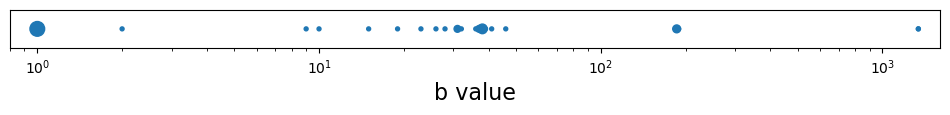

In [15]:
# Plot the resulting b values
s = lambda x : (((x-x.min())/float(x.max()-x.min())+1)*8)**2
b2 = b_opt.copy()
b2[b2<1] = 1
u, c = np.unique(np.c_[np.round(b2)], return_counts=True, axis=0)
yax = 0*u + 1;


plt.figure(figsize=(12,0.5))
plt.scatter(u,yax,s=c*8)
plt.tick_params(left = False, labelleft = False ) 
plt.xscale('log')
plt.xlabel('b value',fontsize=16)
plt.xlim(0.8,1600) 
#plt.ticklabel_format(scilimits=(-5, 8))
plt.show()


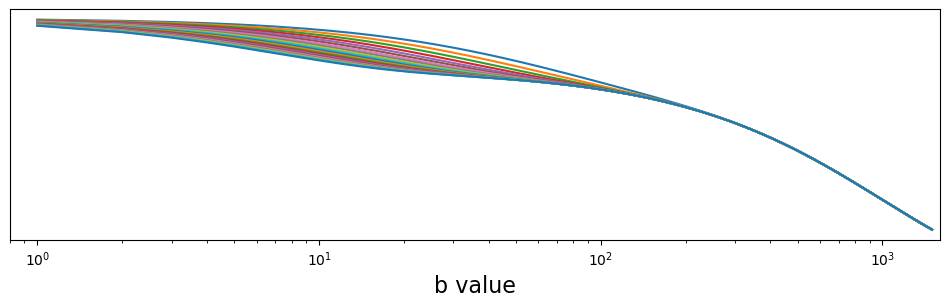

In [6]:
# Plot the signal
plt.figure(figsize=(12,3))
b = np.linspace(1,1500,1500)
for S0 in true_S0s:
    for D in true_Ds:
        for f in true_fs:
            for D_star in true_D_stars:
                curs = ivim_signal(b, S0, D, f, D_star)
                plt.plot(b,curs)
                plt.xscale('log')
                plt.xlabel('b value',fontsize=16)
                plt.xlim(0.8,1600) 
                plt.tick_params(left = False, labelleft = False ) 


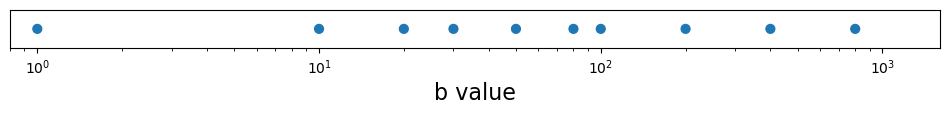

In [17]:
# Some b values from the literature: Luciani A, Vignaud A, Cavet M, et al. Liver cirrhosis: intravoxel incoherent motion MR imaging–pilot study. Radiology 2008;249(3):891-899.
blit = np.array([1, 10, 20, 30, 50, 80, 100,200, 400, 800]) # Replacing the 0 with 1
clit = 0*blit + 5;
yax = 0*blit + 1;


plt.figure(figsize=(12,0.5))
plt.scatter(blit,yax,s=clit*8)
plt.tick_params(left = False, labelleft = False ) 
plt.xscale('log')
plt.xlabel('b value',fontsize=16)
plt.xlim(0.8,1600) 
#plt.ticklabel_format(scilimits=(-5, 8))
plt.show()

